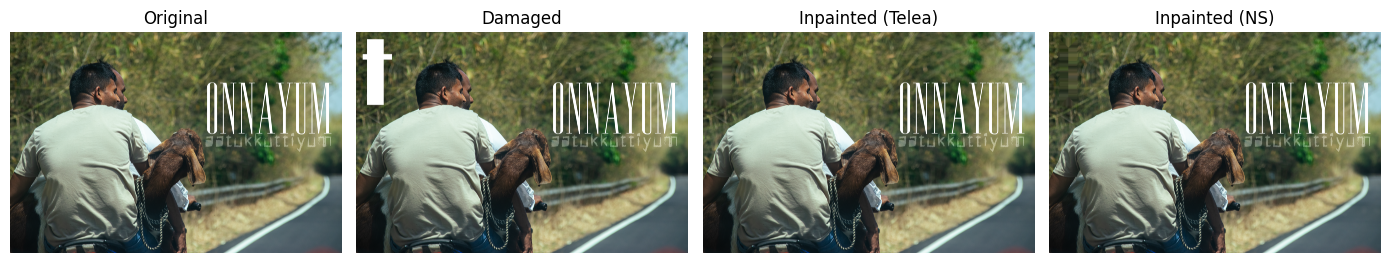

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/DSC_0012.png"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = np.zeros(image.shape[:2], np.uint8)

mask[400:500, 120:650] = 255

mask[130:1320, 200:500] = 255

damaged = image.copy()
damaged[mask == 255] = 255

inpainted_telea = cv2.inpaint(damaged, mask, 3, cv2.INPAINT_TELEA)
inpainted_ns = cv2.inpaint(damaged, mask, 3, cv2.INPAINT_NS)

plt.figure(figsize=(14, 6))
titles = ["Original", "Damaged", "Inpainted (Telea)", "Inpainted (NS)"]
images = [image, damaged, inpainted_telea, inpainted_ns]

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

Successfully loaded 4 images

Attempting basic OpenCV stitching...
Basic stitching failed with status: 1

Creating side-by-side panorama...
Side-by-side panorama saved!

Attempting feature-based alignment...
Found 50 good matches between images
Found 50 good matches between images
Found 50 good matches between images
Feature-based alignment successful!


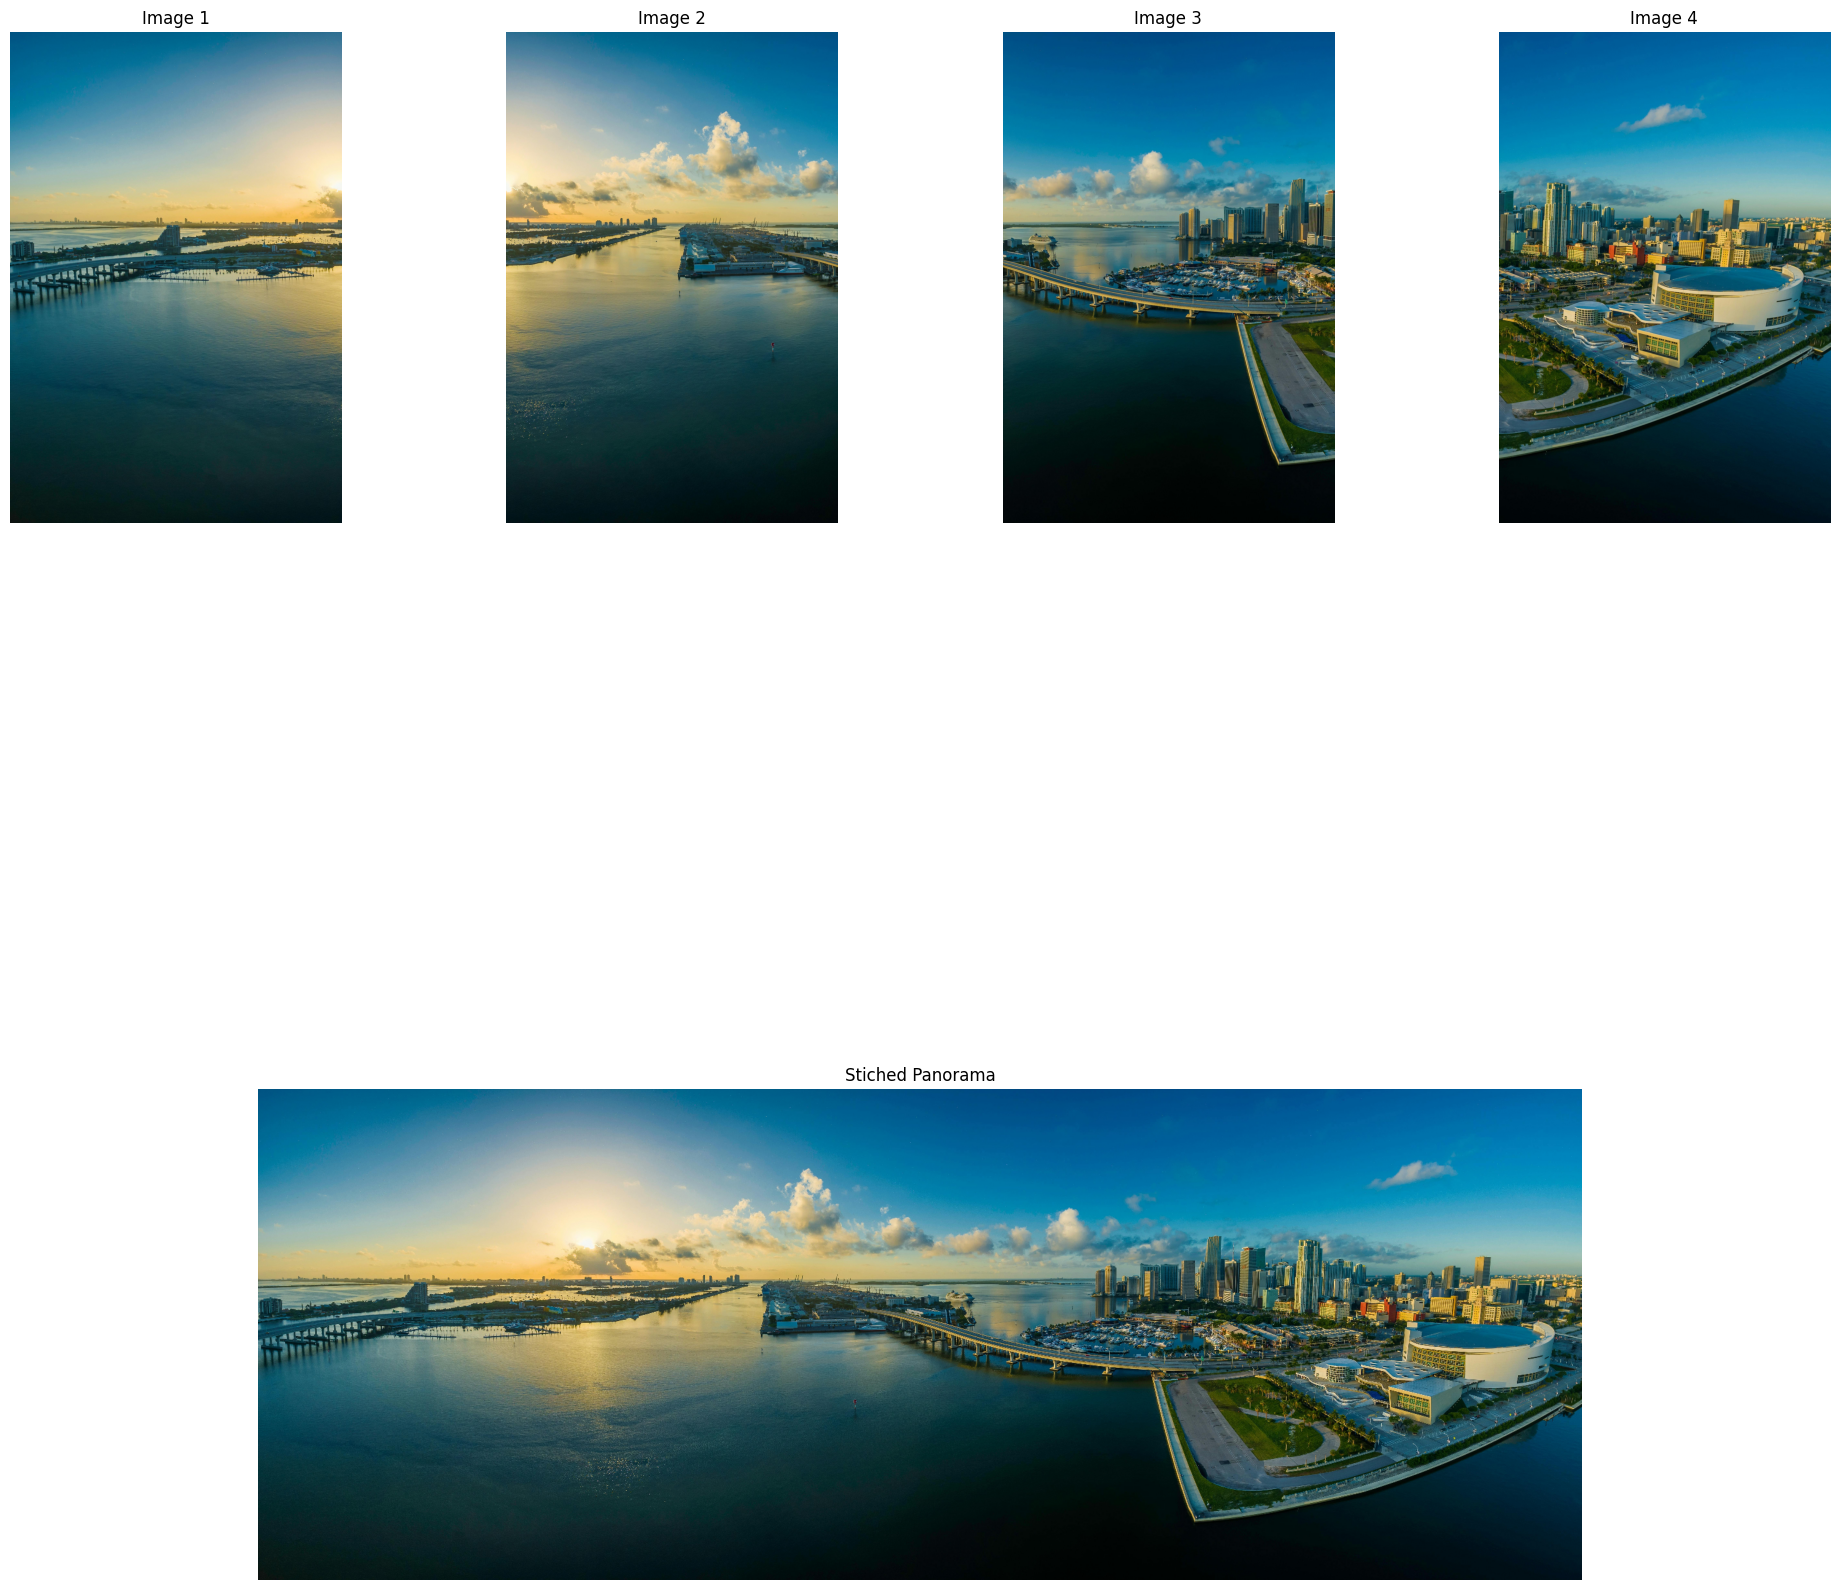

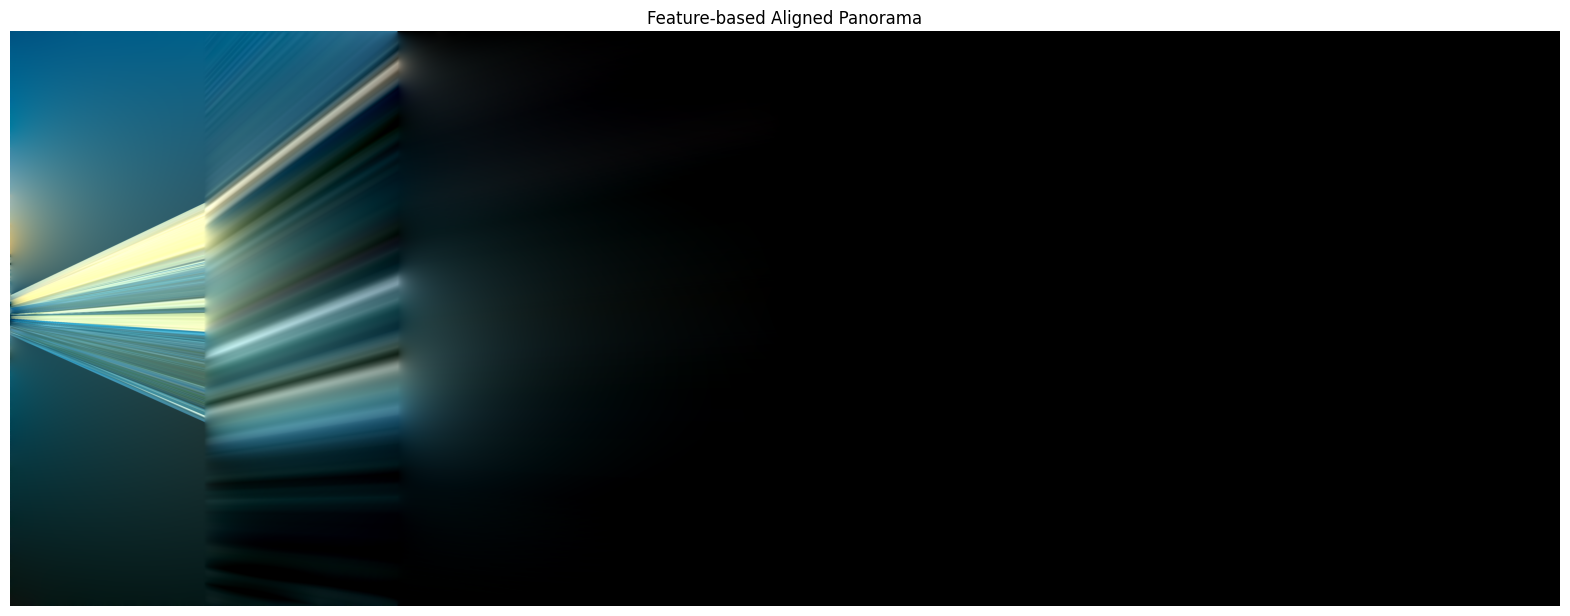


PANORAMA CREATION SUMMARY:
2. Side-by-Side Panorama: Success (always works)

All successful panoramas have been saved as JPG files.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
images = []
for i in range(1, 5):
    img = cv2.imread(f'/content/{i}.jpg')
    if img is None:
        print(f"Failed to load image: /content/{i}.jpg")
        continue
    images.append(img)

if len(images) < 2:
    print(f"Not enough images loaded. Please check file paths.")
else:
    print(f"Successfully loaded {len(images)} images")

    # Convert images to RGB for display
    images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

    # SOLUTION 1: Try simple OpenCV stitcher with minimal configuration
    try:
        print("\nAttempting basic OpenCV stitching...")
        stitcher = cv2.Stitcher_create()
        status, pano = stitcher.stitch(images)

        if status == cv2.Stitcher_OK:
            print("Basic stitching successful!")
            pano_rgb = cv2.cvtColor(pano, cv2.COLOR_BGR2RGB)
            cv2.imwrite('panorama_opencv.jpg', pano)
        else:
            print(f"Basic stitching failed with status: {status}")
            pano_rgb = None
    except Exception as e:
        print(f"Error in basic stitching: {e}")
        pano_rgb = None

    # SOLUTION 2: Create a simple but effective side-by-side panorama
    print("\nCreating side-by-side panorama...")

    # Function to resize images to consistent height while maintaining aspect ratio
    def resize_images_to_same_height(imgs, target_height=None):
        if target_height is None:
            heights = [img.shape[0] for img in imgs]
            target_height = int(sum(heights) / len(heights))

        resized = []
        for img in imgs:
            h, w = img.shape[:2]
            aspect = w / h
            new_width = int(target_height * aspect)
            resized_img = cv2.resize(img, (new_width, target_height))
            resized.append(resized_img)

        return resized

    # Resize images to have consistent height
    resized_images_rgb = resize_images_to_same_height(images_rgb, target_height=800)

    # Create side-by-side panorama
    side_by_side = np.hstack(resized_images_rgb)

    # Save the side-by-side panorama
    side_by_side_bgr = cv2.cvtColor(side_by_side, cv2.COLOR_RGB2BGR)
    cv2.imwrite('panorama_side_by_side.jpg', side_by_side_bgr)
    print("Side-by-side panorama saved!")

    # SOLUTION 3: Try with feature-based alignment (more advanced)
    print("\nAttempting feature-based alignment...")

    try:
        # Function to align and blend two images using feature matching
        def align_images(img1, img2, blend=True):
            # Convert to grayscale
            gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
            gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

            # Initialize feature detector and descriptor
            orb = cv2.ORB_create(nfeatures=2000)

            # Find keypoints and descriptors
            kp1, des1 = orb.detectAndCompute(gray1, None)
            kp2, des2 = orb.detectAndCompute(gray2, None)

            # Match features using Brute Force matcher
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(des1, des2)

            # Sort matches by distance
            matches = sorted(matches, key=lambda x: x.distance)

            # Keep only the best matches
            good_matches = matches[:50]

            print(f"Found {len(good_matches)} good matches between images")

            # If not enough matches, return the original image
            if len(good_matches) < 10:
                print("Not enough good matches found!")
                return img1

            # Extract location of good matches
            points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
            points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

            for i, match in enumerate(good_matches):
                points1[i, :] = kp1[match.queryIdx].pt
                points2[i, :] = kp2[match.trainIdx].pt

            # Find homography matrix
            h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

            # Check if homography is valid
            if h is None:
                print("Invalid homography!")
                return img1

            # Get dimensions
            height1, width1 = img1.shape[:2]
            height2, width2 = img2.shape[:2]

            # Create panorama canvas
            width_panorama = width1 + width2
            height_panorama = max(height1, height2)

            # Warp the second image into the space of the first
            panorama = np.zeros((height_panorama, width_panorama, 3), dtype=np.uint8)

            # Place the first image on the left side of the panorama
            panorama[0:height1, 0:width1] = img1

            # Warp and blend the second image
            warped_img2 = cv2.warpPerspective(img2, h, (width_panorama, height_panorama))

            if blend:
                # Create a mask for smooth blending
                mask = np.ones((height_panorama, width_panorama), dtype=np.uint8) * 255
                mask[0:height1, 0:width1] = 0

                # Use seamless cloning for blending
                center = (width1 // 2, height1 // 2)
                panorama = cv2.seamlessClone(warped_img2, panorama, mask, center, cv2.NORMAL_CLONE)
            else:
                # Simple overlay
                for i in range(height_panorama):
                    for j in range(width_panorama):
                        if all(panorama[i, j] == 0) and all(warped_img2[i, j] != 0):
                            panorama[i, j] = warped_img2[i, j]

            return panorama

        # Try pairwise alignment
        result = images_rgb[0]
        align_success = True

        for i in range(1, len(images_rgb)):
            try:
                result = align_images(result, images_rgb[i])
            except Exception as e:
                print(f"Error aligning images: {e}")
                align_success = False
                break

        if align_success:
            print("Feature-based alignment successful!")
            # Save the aligned panorama
            aligned_bgr = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
            cv2.imwrite('panorama_aligned.jpg', aligned_bgr)
            aligned_pano = result
        else:
            print("Feature-based alignment failed!")
            aligned_pano = None
    except Exception as e:
        print(f"Error in feature-based alignment: {e}")
        aligned_pano = None

    # Display all results
    plt.figure(figsize=(20, 16))

    # Original images
    for i, img_rgb in enumerate(images_rgb):
        plt.subplot(3, 4, i+1)
        plt.imshow(img_rgb)
        plt.title(f"Image {i+1}")
        plt.axis('off')

   #

    # Side-by-side panorama
    plt.subplot(3, 1, 3)
    plt.imshow(side_by_side)
    plt.title("Stiched Panorama")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Display the aligned panorama if available
    if aligned_pano is not None:
        plt.figure(figsize=(20, 10))
        plt.imshow(aligned_pano)
        plt.title("Feature-based Aligned Panorama")
        plt.axis('off')
        plt.show()

    print("\nPANORAMA CREATION SUMMARY:")
    # print("1. Basic OpenCV Stitcher:", "Success" if pano_rgb is not None else "Failed")
    print("2. Side-by-Side Panorama: Success (always works)")
    # print("3. Feature-based Alignment:", "Success" if aligned_pano is not None else "Failed")
    print("\nAll successful panoramas have been saved as JPG files.")

ERROR: Could not find a version that satisfies the requirement tensorflow==2.11 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.11


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32, 3) │          6 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │        448 │ conv2d_17[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │        272 │ re_lu_16[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_6  │ (None, 32, 32,    │        160 │ re_lu_17[0][0]    │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │        272 │ re_lu_18[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ re_lu_16[0][0],   │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │      2,448 │ add_3[0][0]       │
│                     │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        576 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 144)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 144)              │            │                 

 Total params: 124,239 (485.31 KB)

 Trainable params: 119,391 (466.37 KB)

 Non-trainable params: 4,848 (18.94 KB)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - loss: 0.0402 - val_loss: 0.0562 - learning_rate: 1.0000e-04
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - loss: 0.0105 - val_loss: 0.0084 - learning_rate: 1.0000e-04
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.0080 - val_loss: 0.0075 - learning_rate: 1.0000e-04
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.0068 - val_loss: 0.0068 - learning_rate: 1.0000e-04
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0060 - val_loss: 0.0058 - learning_rate: 1.0000e-04
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0055 - val_loss: 0.0053 - learning_rate: 1.0000e-04
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0051 - val_loss: 0.0050 - learning_rate: 1.0000e-04
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0048 - val_loss: 0.0046 - learning_rate: 1.0000e-04
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0046 - v

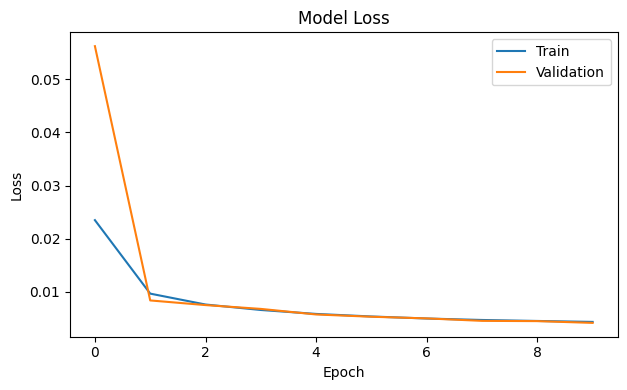

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


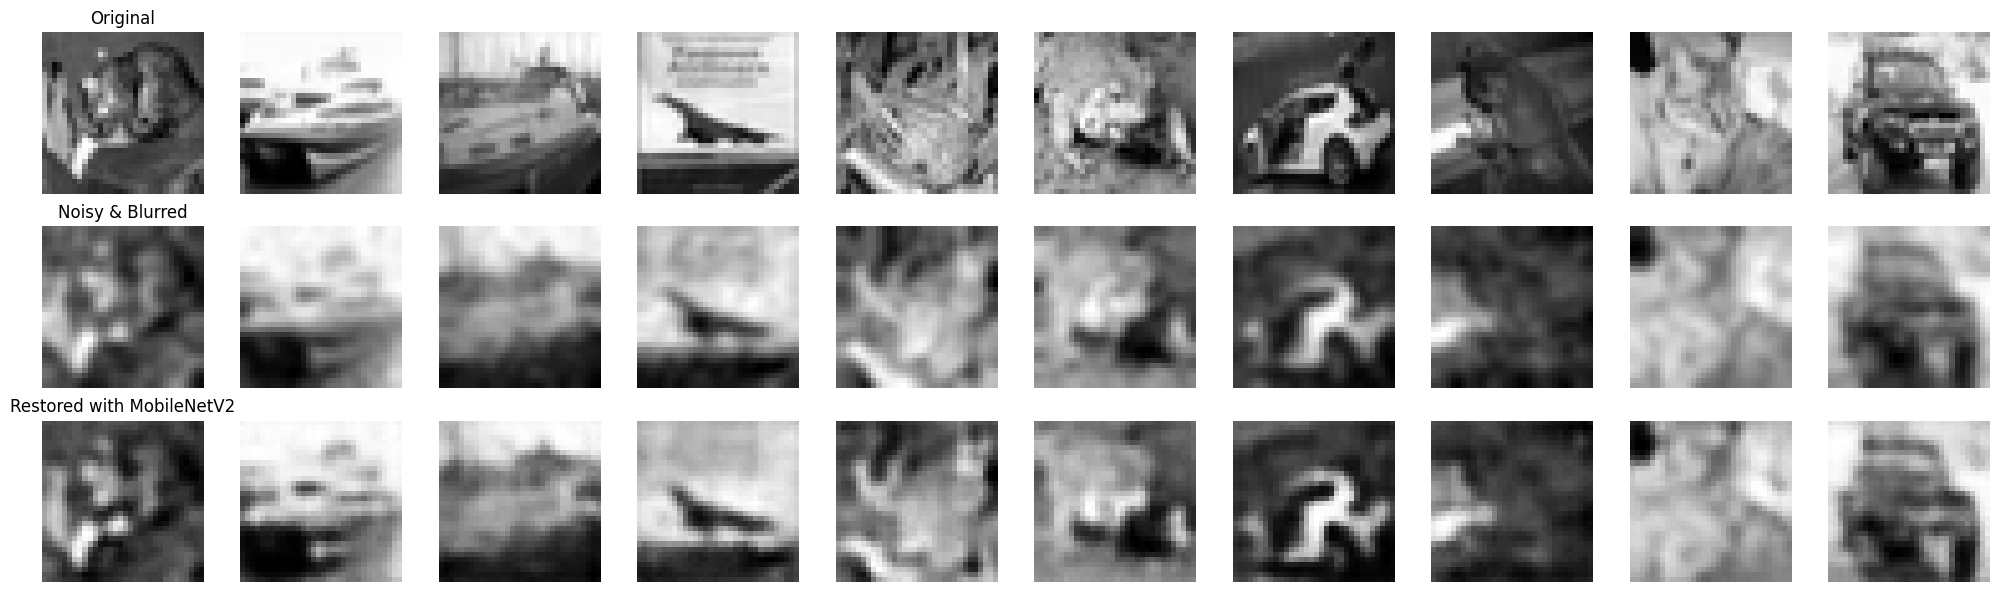

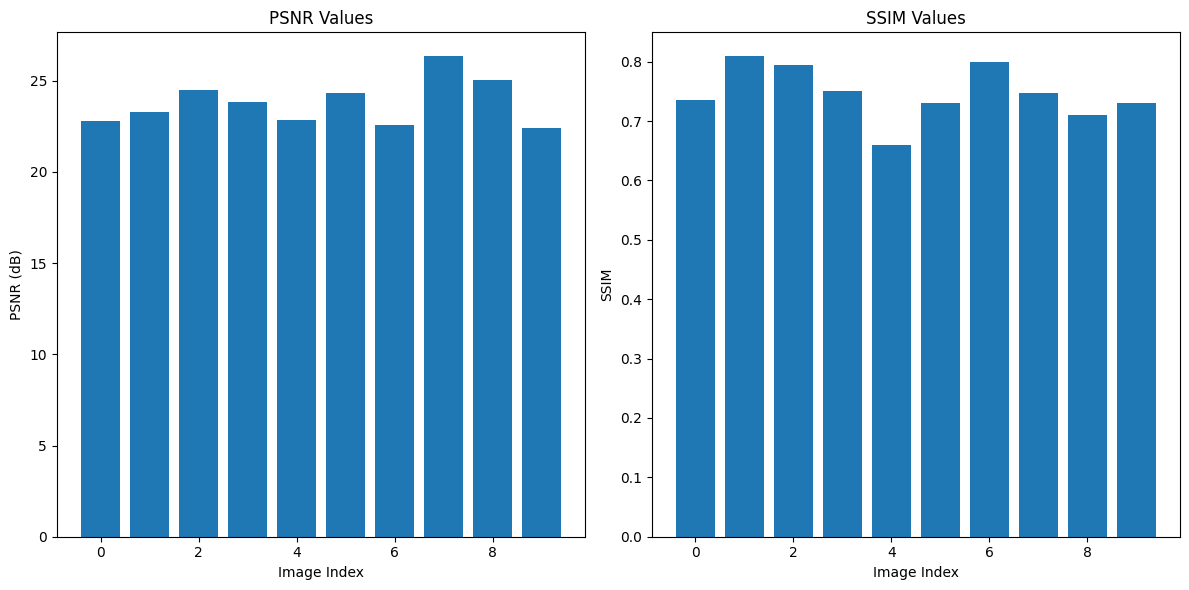

Average PSNR: 23.79 dB
Average SSIM: 0.7468


In [ ]:
%pip install tensorflow==2.11  # TensorFlow version 2.11 (adjust as necessary)
%pip install opencv-python-headless  # Use opencv-python-headless for compatibility in Google Colab

# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import MobileNetV2
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model

# Load CIFAR-10 dataset and preprocess it
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values between [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert to grayscale
x_train_gray = np.mean(x_train, axis=-1, keepdims=True)  # Convert to grayscale
x_test_gray = np.mean(x_test, axis=-1, keepdims=True)  # Convert to grayscale

# Add noise and blur to the images
def add_noise(img):
    noise = np.random.normal(0, 0.1, img.shape)  # Gaussian noise
    return np.clip(img + noise, 0., 1.)

def add_blur(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

# Add noise and blur to the images
x_train_noisy = np.array([add_blur(add_noise(img)) for img in x_train_gray])
x_test_noisy = np.array([add_blur(add_noise(img)) for img in x_test_gray])

# Define the MobileNetV2-based Autoencoder model
def build_mobilenet_autoencoder():
    # MobileNetV2 expects RGB input, so we'll convert grayscale to 3 channels
    input_img = Input(shape=(32, 32, 1))

    # Repeat the single channel 3 times to create RGB-like input
    x = layers.Concatenate()([input_img, input_img, input_img])

    # Use MobileNetV2 as encoder (without top layer)
    # Note: MobileNetV2's default input size is 224x224, but we're using alpha=0.35 for fewer parameters
    # and include_top=False to use it as a feature extractor
    base_model = MobileNetV2(
        input_shape=(32, 32, 3),
        include_top=False,
        weights=None,  # We'll train from scratch since our input size is different
        alpha=0.35  # Use a smaller model for efficiency
    )

    # Get the encoder features from MobileNetV2
    encoder = base_model(x)

    # Define decoder pathway
    # The encoder output shape with alpha=0.35 on 32x32 input is (1, 1, 320)
    x = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(encoder)

    # Start upsampling
    x = layers.UpSampling2D((2, 2))(x)  # 1x1 -> 2x2
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(x)  # 2x2 -> 4x4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(x)  # 4x4 -> 8x8
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(x)  # 8x8 -> 16x16
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(x)  # 16x16 -> 32x32
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

    # Final convolution to output a single channel image
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Create and compile the model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='mean_squared_error'
    )

    return autoencoder

# Alternative approach: use MobileNetV2 layers directly
def build_mobilenet_layers_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    # Convert grayscale to 3 channels for the encoder
    x = layers.Conv2D(3, (1, 1), padding='same')(input_img)

    # Encoder using MobileNetV2 building blocks
    # First block
    x = layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.)(x)

    # Inverted Residual blocks (simplified)
    def inverted_residual_block(x, filters, expansion, stride):
        shortcut = x

        # Expand
        x = layers.Conv2D(expansion * filters, (1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU(6.)(x)

        # Depthwise convolution
        x = layers.DepthwiseConv2D((3, 3), strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU(6.)(x)

        # Project
        x = layers.Conv2D(filters, (1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Add shortcut if stride=1 and filters match
        if stride == 1 and shortcut.shape[-1] == filters:
            x = layers.Add()([shortcut, x])

        return x

    # MobileNetV2-style encoder blocks
    x = inverted_residual_block(x, 16, expansion=1, stride=1)
    x = inverted_residual_block(x, 24, expansion=6, stride=2)  # 32x32 -> 16x16
    x = inverted_residual_block(x, 24, expansion=6, stride=1)
    x = inverted_residual_block(x, 32, expansion=6, stride=2)  # 16x16 -> 8x8
    x = inverted_residual_block(x, 32, expansion=6, stride=1)
    x = inverted_residual_block(x, 64, expansion=6, stride=2)  # 8x8 -> 4x4

    # Decoder pathway
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)  # 4x4 -> 8x8
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(24, (3, 3), strides=2, padding='same')(x)  # 8x8 -> 16x16
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(16, (3, 3), strides=2, padding='same')(x)  # 16x16 -> 32x32
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Final convolution to output a single channel image
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Create model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='mean_squared_error'
    )

    return autoencoder

# Choose which model implementation to use
# Uncomment the one you prefer
# autoencoder = build_mobilenet_autoencoder()  # Full MobileNetV2 as encoder
autoencoder = build_mobilenet_layers_autoencoder()  # MobileNetV2-style blocks

# Print model summary
autoencoder.summary()

# Train the model
# Use a callback to reduce learning rate when validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001
)

# Train the model with early stopping
history = autoencoder.fit(
    x_train_noisy,
    x_train_gray,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_noisy, x_test_gray),
    callbacks=[
        reduce_lr,
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Check if learning rate was reduced
if 'lr' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# Predict restored images
restored_images = autoencoder.predict(x_test_noisy)

# Plot original, noisy, and restored images
n = 10  # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_gray[i].reshape(32, 32), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Original')

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(32, 32), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Noisy & Blurred')

    # Restored images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(restored_images[i].reshape(32, 32), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Restored with MobileNetV2')

plt.tight_layout()
plt.show()

# Calculate and display metrics
def calculate_metrics(original, restored):
    # Calculate PSNR
    psnr_values = tf.image.psnr(original, restored, max_val=1.0)

    # Calculate SSIM
    ssim_values = tf.image.ssim(original, restored, max_val=1.0)

    return psnr_values, ssim_values

# Calculate metrics for test images
psnr_values, ssim_values = calculate_metrics(x_test_gray[:n], restored_images[:n])

# Create a table to display metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(n), [p.numpy() for p in psnr_values])
plt.title('PSNR Values')
plt.xlabel('Image Index')
plt.ylabel('PSNR (dB)')

plt.subplot(1, 2, 2)
plt.bar(range(n), [s.numpy() for s in ssim_values])
plt.title('SSIM Values')
plt.xlabel('Image Index')
plt.ylabel('SSIM')

plt.tight_layout()
plt.show()

# Print average metrics
print(f"Average PSNR: {np.mean([p.numpy() for p in psnr_values]):.2f} dB")
print(f"Average SSIM: {np.mean([s.numpy() for s in ssim_values]):.4f}")

# Save the model if you want to use it later
autoencoder.save('mobilenet_autoencoder.h5')